# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import sympy as sp
import casadi as ca

# Utils

In [2]:
def compare_results(q1, u1, q2, u2, T):
    state_labels = ["x (m)", "y (m)", "theta (rad)"]
    input_labels = ["v (linear velocity)", "w (angular velocity)"]
    
    t_q = np.linspace(0, T, q1.shape[1])
    t_u = np.linspace(0, T, u1.shape[1])

    # ---- 1. Plot State Evolution Over Time ----
    plt.figure(figsize=(11, 8))
    for i in range(3):
        plt.subplot(3, 1, i + 1)
        plt.plot(t_q, q1[i, :], "--r", label=state_labels[i] + ' Set 1')
        plt.plot(t_q, q2[i, :], "--g", label=state_labels[i] + ' Set 2')
        plt.xlabel("Time (s)")
        plt.ylabel(state_labels[i])
        plt.legend()
        plt.grid()
    
    plt.suptitle("State Evolution Comparison")
    plt.tight_layout()
    plt.show()

    # ---- 2. Plot Control Inputs Over Time ----
    plt.figure(figsize=(10, 5))
    for i in range(2):
        plt.subplot(2, 1, i + 1)
        plt.step(t_u, u1[i, :], where='post', label=input_labels[i] + ' Set 1', color='blue')
        plt.step(t_u, u2[i, :], where='post', label=input_labels[i] + ' Set 2', color='orange', linestyle='--')
        plt.ylabel(input_labels[i])
        plt.grid()
        plt.legend()
        if i == 1:
            plt.xlabel("Time (s)")

    plt.suptitle("Control Input Comparison")
    plt.tight_layout()
    plt.show()

    # ---- 3. Plot 2D Trajectories with Orientation Arrows ----
    plt.figure(figsize=(8, 6))
    plt.plot(q1[0, :], q1[1, :], 'r-', label='Trajectory Set 1')
    plt.plot(q2[0, :], q2[1, :], 'g--', label='Trajectory Set 2')

    # Add orientation arrows
    step = 10  # plot arrow every N points
    scale = 0.2

    for i in range(0, q1.shape[1], step):
        dx1 = scale * np.cos(q1[2, i])
        dy1 = scale * np.sin(q1[2, i])
        plt.arrow(q1[0, i], q1[1, i], dx1, dy1, head_width=0.05, head_length=0.1, fc='r', ec='r')

        dx2 = scale * np.cos(q2[2, i])
        dy2 = scale * np.sin(q2[2, i])
        plt.arrow(q2[0, i], q2[1, i], dx2, dy2, head_width=0.05, head_length=0.1, fc='g', ec='g')

    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.title("2D Trajectory Comparison with Orientation")
    plt.axis('equal')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

# Creating Differential Robot Model

In [53]:
class DiffDriveRobotSimulation:
    def __init__(self, q0, Tf, dt, input_fun, method="euler"):
        self.q0 = q0
        self.Tf = Tf
        self.dt = dt
        self.input_fun = input_fun
        self.q_hist = None
        self.t_hist = None
        self.u_hist = None
        self.method = method  # Choose between 'euler' and 'rk4'


    def diffdrive_kinematics(self, q, u): 
        x, y, theta = q
        v, w = u
        
        d_x = v*np.cos(theta)
        d_y = v*np.sin(theta)
        d_theta = w

        q_dot = np.array([d_x, d_y, d_theta])

        return q_dot
           
    def forward_euler_w_input(self):
        """
        Performs forward Euler integration.
        """
        t_hist = np.arange(0, self.Tf, self.dt)
        num_points = len(t_hist)
        dim_x = len(self.q0)
        q_hist = np.zeros((dim_x, num_points))
        u_hist = np.zeros((2, num_points))
        q_hist[:, 0] = self.q0
        
        for k in range(num_points - 1):
            t_k = t_hist[k]
            u_k = self.input_fun(t_k)
            q_dot = self.diffdrive_kinematics(q_hist[:, k], u_k)
            q_hist[:, k + 1] = q_hist[:, k] + self.dt * q_dot
            u_hist[:, k] = u_k

        self.q_hist = q_hist
        self.t_hist = t_hist
        self.u_hist = u_hist

        return q_hist, t_hist, u_hist

    def runge_kutta_w_input(self):
        """Performs Runge-Kutta 4 integration."""
        t_hist = np.arange(0, self.Tf, self.dt)
        num_points = len(t_hist)
        dim_x = len(self.q0)
        q_hist = np.zeros((dim_x, num_points))
        u_hist = np.zeros((2, num_points))
        q_hist[:, 0] = self.q0
        
        for k in range(num_points - 1):
            t_k = t_hist[k]
            u_k = self.input_fun(t_k)
            q_hist[:, k + 1] = self.rk4_step(q_hist[:, k], u_k)
            u_hist[:, k] = u_k

        self.q_hist = q_hist
        self.t_hist = t_hist
        self.u_hist = u_hist
        
        return q_hist, t_hist, u_hist

    def rk4_step(self, q, u):
        """Performs a single step of Runge-Kutta 4 integration."""
        k1 = self.diffdrive_kinematics(q, u)
        k2 = self.diffdrive_kinematics(q + 0.5 * self.dt * k1, u)
        k3 = self.diffdrive_kinematics(q + 0.5 * self.dt * k2, u)
        k4 = self.diffdrive_kinematics(q + self.dt * k3, u)
        return q + (self.dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

    def simulate(self):
        """Runs the simulation using the selected integration method."""
        if self.method == "euler":
            return self.forward_euler_w_input()
        elif self.method == "rk4":
            return self.runge_kutta_w_input()
        else:
            raise ValueError("Invalid integration method. Choose 'euler' or 'rk4'.")
    
    def plot_results(self):
        """
        Plots the simulation results.
        """
        state_labels = ["x (m)", "y (m)", "theta (rad)"]
        
        plt.figure(figsize=(12,8))
        for i in range(3):
            plt.subplot(3, 1, i + 1)
            plt.plot(self.t_hist, self.q_hist[i, :], "-o", markersize=3)
            plt.xlabel("Time (s)")
            plt.ylabel(state_labels[i])
            plt.grid()
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(12, 4))
        plt.plot(self.t_hist, self.u_hist[0, :], label="v (linear velocity)", color='blue')
        plt.plot(self.t_hist, self.u_hist[1, :], label="w (angular velocity)", color='red')
        plt.xlabel("Time (s)")
        plt.ylabel("Control Inputs")
        plt.title("Control Inputs [v, w]")
        plt.legend()
        plt.grid()
        plt.show()
        
        """
        Plots the x-y trajectory with orientation (theta) arrows.
        """
        if self.q_hist is None or self.t_hist is None:
            raise ValueError("Simulation not run yet. Call simulate() first.")
    
        x = self.q_hist[0, :]
        y = self.q_hist[1, :]
        theta = self.q_hist[2, :]
    
        plt.figure(figsize=(8, 6))
        plt.plot(x, y, label="Trajectory", color='blue')
        
        # Plot orientation arrows
        step = 10
        scale = 0.2
        for i in range(0, len(x), step):
            dx = scale * np.cos(theta[i])
            dy = scale * np.sin(theta[i])
            plt.arrow(x[i], y[i], dx, dy, head_width=0.05, head_length=0.1, fc='red', ec='red')
    
        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.title("Trajectory with Orientation")
        plt.axis("equal")
        plt.grid(True)
        plt.legend()
        plt.show()

    def animate_trajectory(self):
        """
        Creates an animation of trajectory.
        """
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4)
        ax.set_title("Robot Trajectory")
        line, = ax.plot([], [], 'bo-', markersize=3)

        def update_frame(frame):
            line.set_data(self.q_hist[0, :frame], self.q_hist[1, :frame])
            return line,

        ani = FuncAnimation(fig, update_frame, frames=len(self.t_hist), interval=100, blit=True)
        return HTML(ani.to_jshtml())

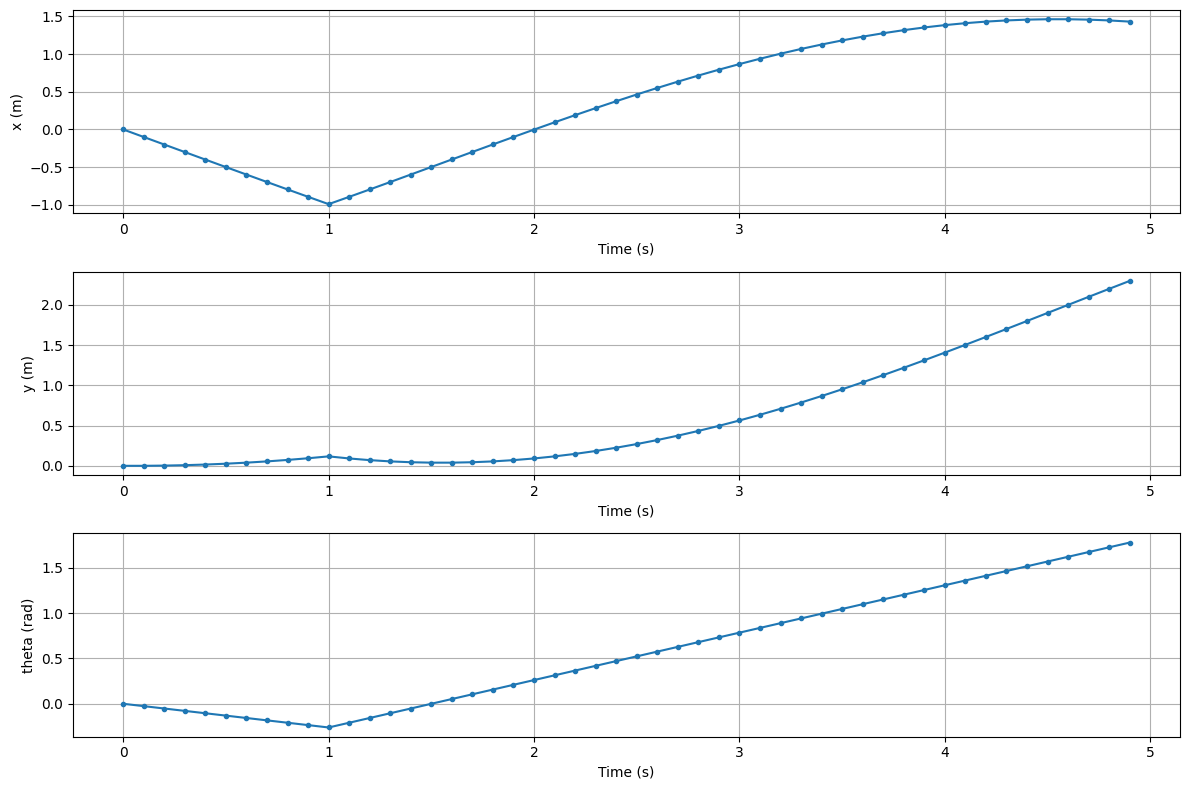

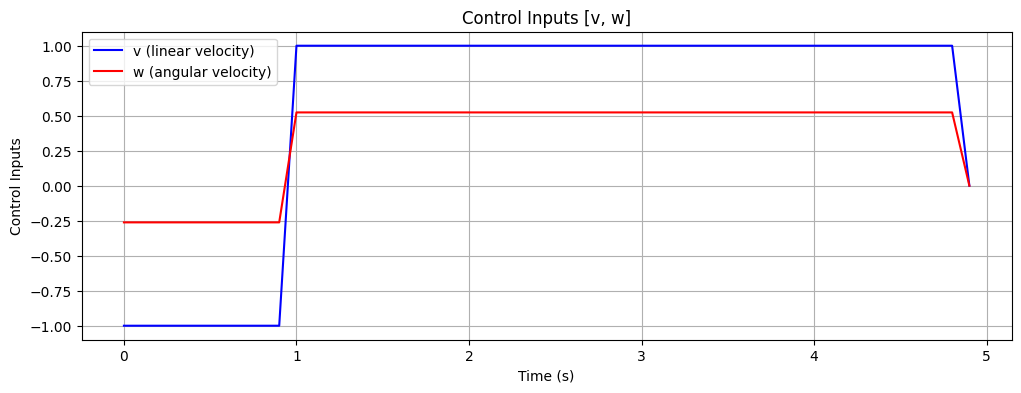

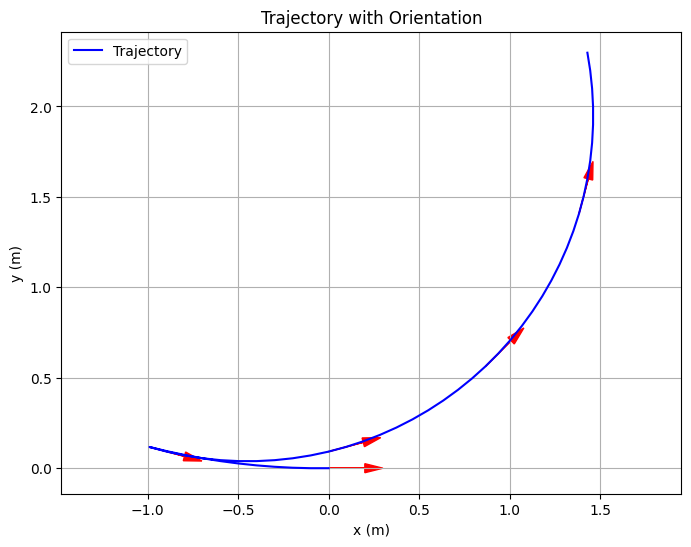

In [77]:
q0 = np.array([0,0,0])
Tf = 5
dt = 0.1

def input_fun(t):
    if t < 1.0:
        return np.array([-1, -np.pi/12]) 
    else:
        return np.array([1, np.pi/6])

robot = DiffDriveRobotSimulation(q0, Tf, dt, input_fun, method="euler")
q_hist, t_hist, u_hist = robot.simulate()
robot.plot_results()

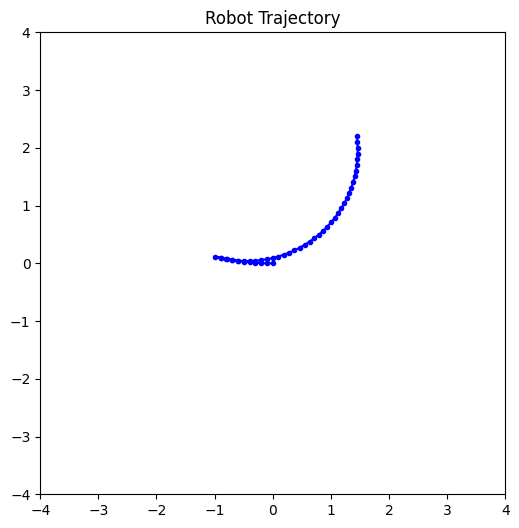

In [55]:
HTML(robot.animate_trajectory().data)

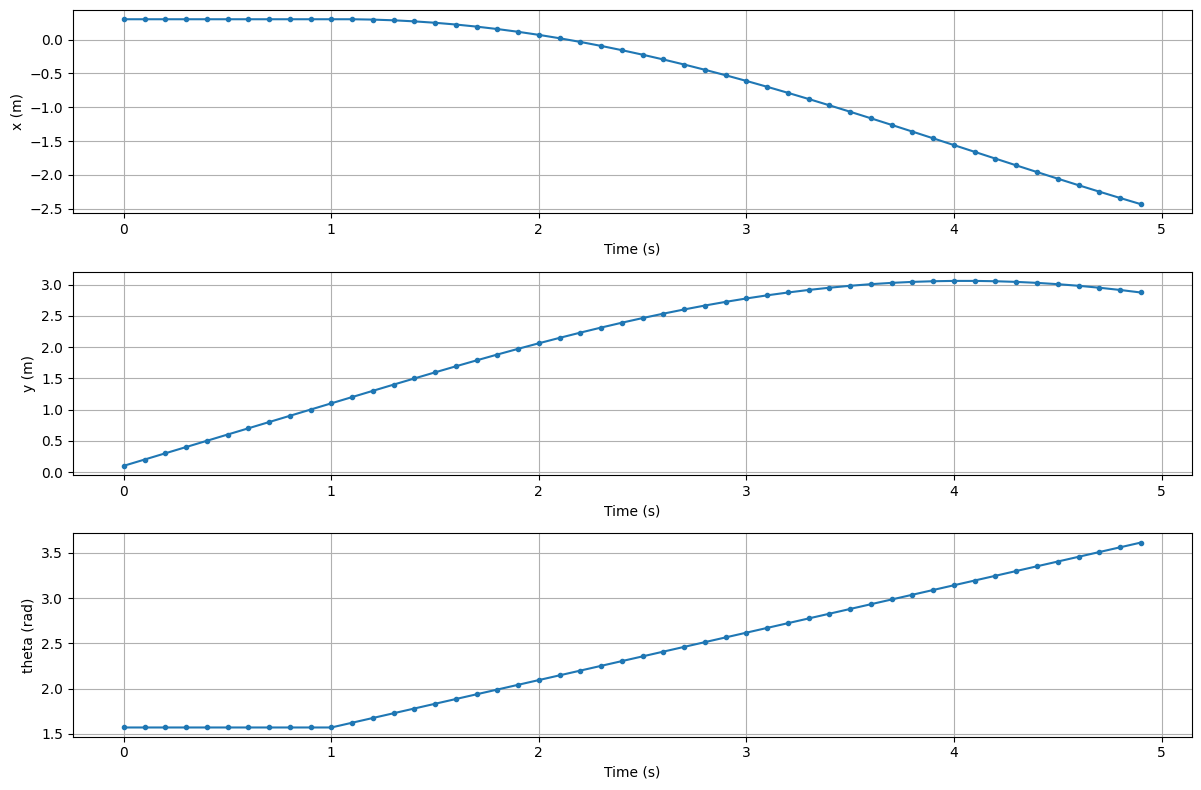

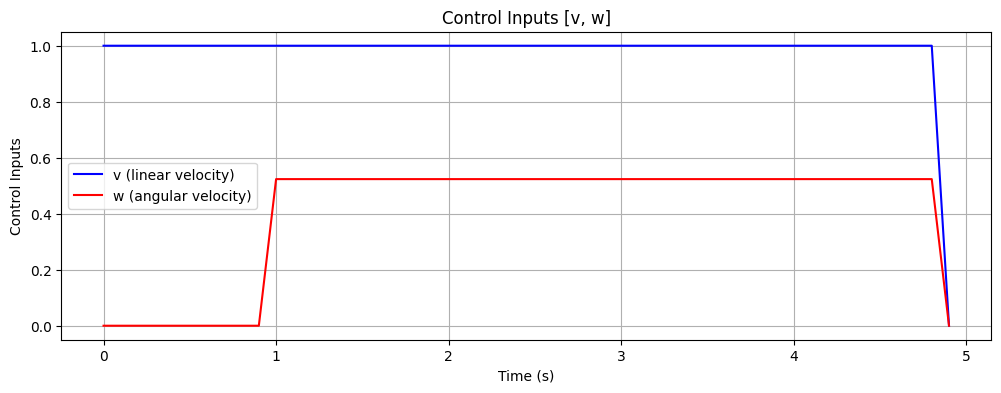

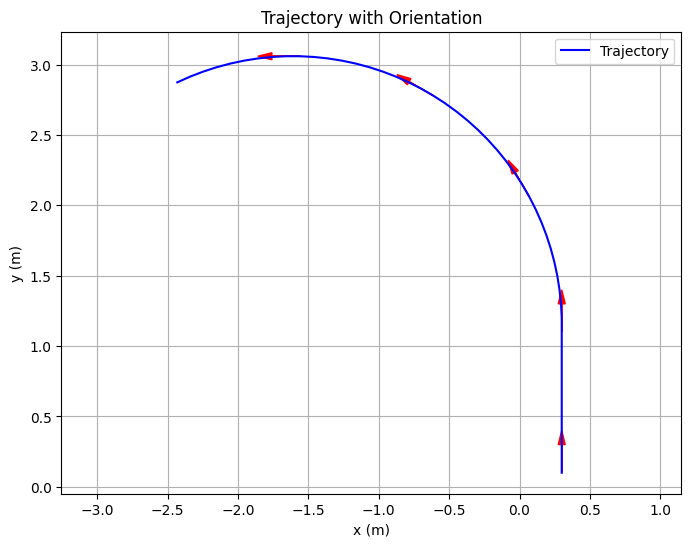

In [59]:
q0_1 = np.array([0.3,0.1,np.pi/2])
Tf = 5
dt = 0.1

def input_fun(t):
    if t < 1.0:
        return np.array([1, 0]) 
    else:
        return np.array([1, np.pi/6])

robot1 = DiffDriveRobotSimulation(q0_1, Tf, dt, input_fun, method="euler")
q_hist1, t_hist1, u_hist1 = robot1.simulate()
robot1.plot_results()

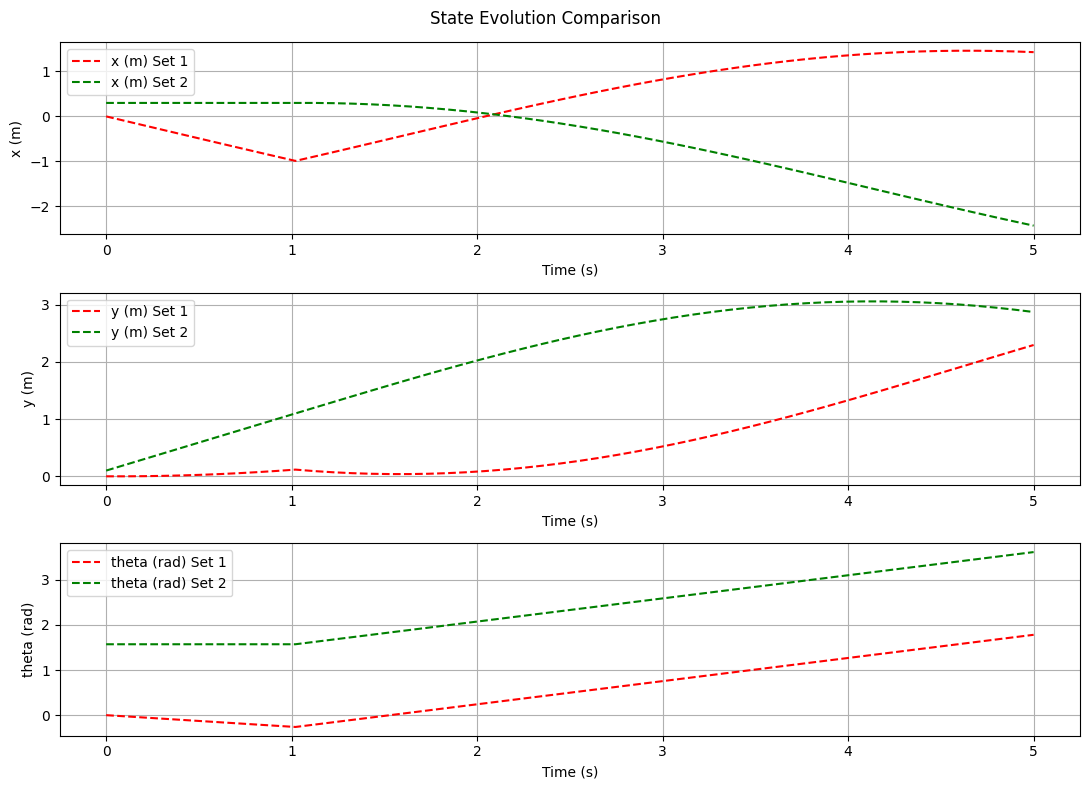

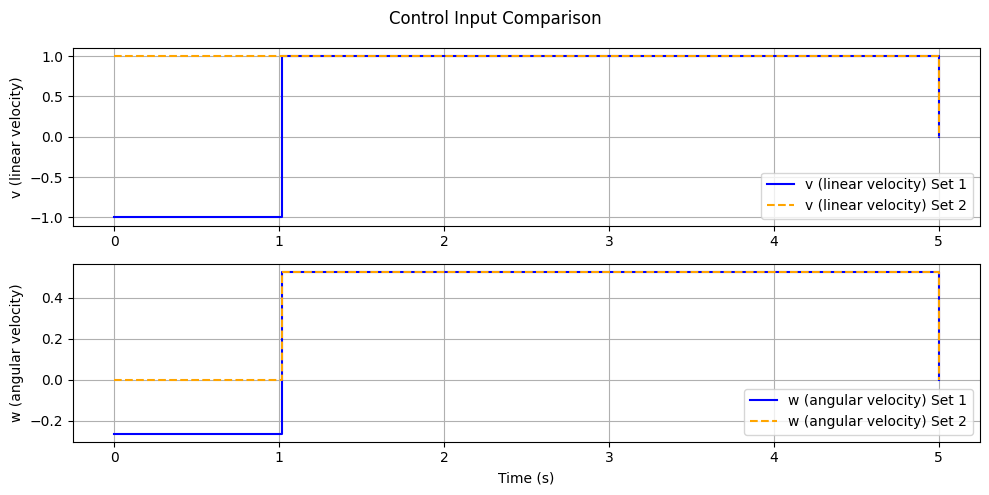

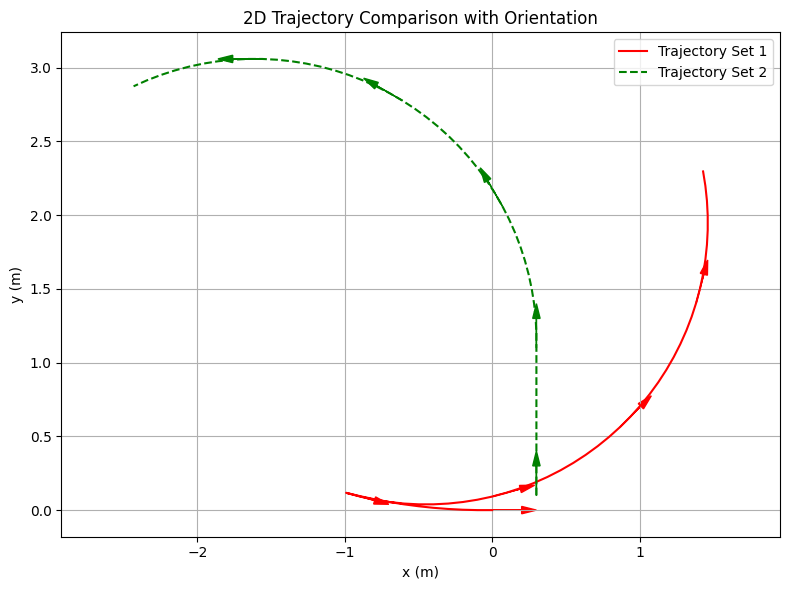

In [101]:
compare_results(q_hist, u_hist, q_hist1, u_hist1, Tf)

# Check Non-linear controllability

In [102]:
# Define symbolic variables
x, y, theta = sp.symbols('x y theta')
v, w = sp.symbols('v w')

# Define state vector
q = sp.Matrix([x, y, theta])

# Define input vector fields (g1 and g2)
g1 = sp.Matrix([
    sp.cos(theta),
    sp.sin(theta),
    0
])

g2 = sp.Matrix([
    0,
    0,
    1
])

# Compute Lie bracket [g1, g2] = ∂g2/∂q * g1 - ∂g1/∂q * g2
def lie_bracket(f, g, q_vars):
    df = f.jacobian(q_vars)
    dg = g.jacobian(q_vars)
    return dg * f - df * g

# Compute [g1, g2]
bracket = lie_bracket(g1, g2, q)

# Print vector fields and Lie bracket
print("g1 (associated with v):")
sp.pprint(g1)
print("\ng2 (associated with w):")
sp.pprint(g2)
print("\nLie bracket [g1, g2]:")
sp.pprint(bracket)

# Check linear independence (by computing determinant of Gram matrix)
span_matrix = sp.Matrix.hstack(g1, g2, bracket)
rank = span_matrix.rank()
print(f"\nRank of span {rank} →", "Locally controllable!" if rank == 3 else "Not controllable.")

g1 (associated with v):
⎡cos(θ)⎤
⎢      ⎥
⎢sin(θ)⎥
⎢      ⎥
⎣  0   ⎦

g2 (associated with w):
⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣1⎦

Lie bracket [g1, g2]:
⎡sin(θ) ⎤
⎢       ⎥
⎢-cos(θ)⎥
⎢       ⎥
⎣   0   ⎦

Rank of span 3 → Locally controllable!


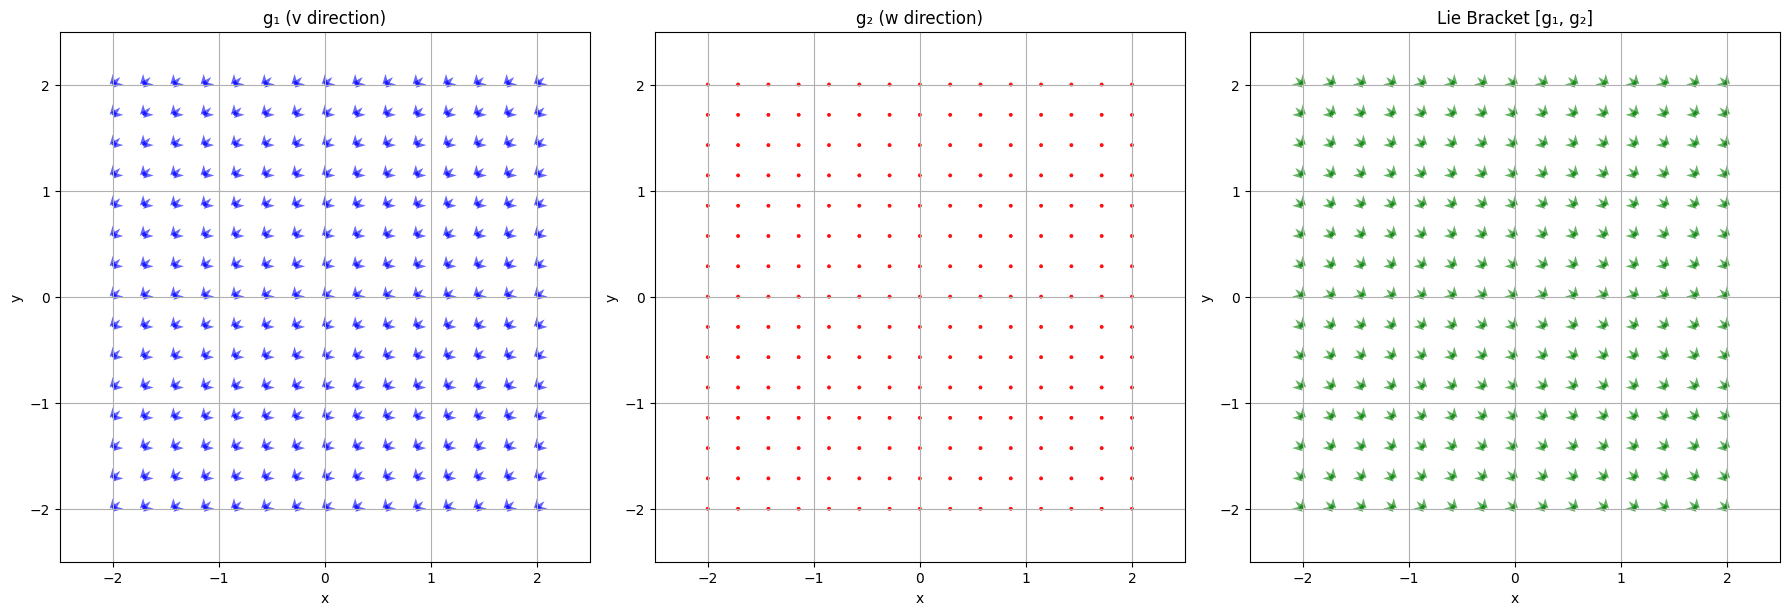

In [103]:
# Define grid
x_vals = np.linspace(-2, 2, 15)
y_vals = np.linspace(-2, 2, 15)
theta_vals = [0, np.pi / 4, np.pi / 2]  # fixed orientations for visualization

# Lie bracket vector field
def g1(theta):
    return np.array([np.cos(theta), np.sin(theta), 0])

def g2(_theta):
    return np.array([0, 0, 1])

def lie_bracket_g1_g2(theta):
    # [g1, g2] = d(g2)/dq * g1 - d(g1)/dq * g2
    # In this case, we know it symbolically:
    return np.array([-np.sin(theta), np.cos(theta), 0])

# Plot vector fields
# g₁: Shows movement in the direction of the robot's heading.
# g₂: No spatial movement, only affects orientation (thus zero arrows in XY).
# [g₁, g₂]: A direction perpendicular to g₁, capturing curved motion—this is what makes the system controllable

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
titles = ['g₁ (v direction)', 'g₂ (w direction)', 'Lie Bracket [g₁, g₂]']
functions = [g1, g2, lie_bracket_g1_g2]
colors = ['blue', 'red', 'green']

for ax, title, vec_func, color in zip(axs, titles, functions, colors):
    for theta in theta_vals:
        for x in x_vals:
            for y in y_vals:
                vec = vec_func(theta)
                ax.quiver(x, y, vec[0], vec[1], angles='xy', scale_units='xy', scale=10, color=color, alpha=0.6)
    
    ax.set_title(title)
    ax.set_xlim([-2.5, 2.5])
    ax.set_ylim([-2.5, 2.5])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.grid(True)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()


In [105]:
# # Vector fields
# def g1(theta):
#     return np.array([np.cos(theta), np.sin(theta), 0])

# def g2(theta):
#     return np.array([0, 0, 1])  # no XY motion, only angular

# def lie_bracket(theta):
#     return np.array([-np.sin(theta), np.cos(theta), 0])

# # Grid for plotting
# x_vals = np.linspace(-2, 2, 10)
# y_vals = np.linspace(-2, 2, 10)
# X, Y = np.meshgrid(x_vals, y_vals)

# # Prepare figure
# fig, ax = plt.subplots(figsize=(6, 6))
# q1_field = ax.quiver(X, Y, np.zeros_like(X), np.zeros_like(Y), color='blue', label='g₁')
# q2_field = ax.quiver(X, Y, np.zeros_like(X), np.zeros_like(Y), color='red', label='g₂')
# bracket_field = ax.quiver(X, Y, np.zeros_like(X), np.zeros_like(Y), color='green', label='[g₁, g₂]')
# ax.set_xlim(-2.5, 2.5)
# ax.set_ylim(-2.5, 2.5)
# ax.set_aspect('equal')
# ax.grid(True)
# ax.set_title("Vector Fields: g₁ (blue), g₂ (red), [g₁, g₂] (green)")
# ax.legend()

# # Animation function
# def update(frame):
#     theta = frame
#     g1_vec = g1(theta)
#     g2_vec = g2(theta)
#     br_vec = lie_bracket(theta)

#     U1 = np.full_like(X, g1_vec[0])
#     V1 = np.full_like(Y, g1_vec[1])
#     q1_field.set_UVC(U1, V1)

#     U2 = np.full_like(X, g2_vec[0])
#     V2 = np.full_like(Y, g2_vec[1])
#     q2_field.set_UVC(U2, V2)

#     Ub = np.full_like(X, br_vec[0])
#     Vb = np.full_like(Y, br_vec[1])
#     bracket_field.set_UVC(Ub, Vb)

#     ax.set_title(f"Vector Fields at θ = {np.round(theta, 2)} rad")
#     return q1_field, q2_field, bracket_field

# # Create animation
# thetas = np.linspace(0, 2*np.pi, 60)
# ani = FuncAnimation(fig, update, frames=thetas, interval=100)

# # Show animation
# HTML(ani.to_jshtml())


# Non Linear MPC

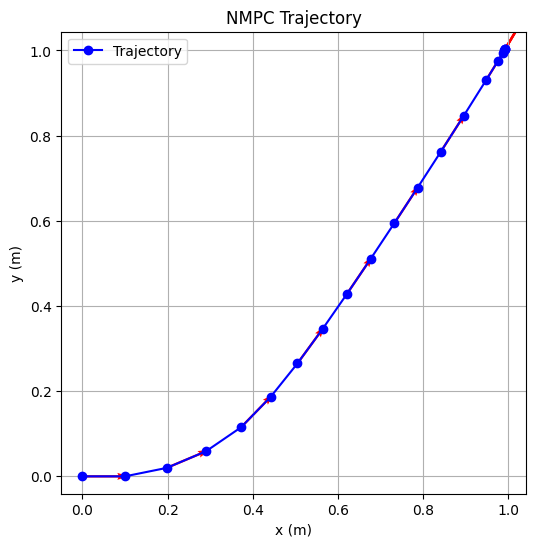

In [118]:
# Parameters
T = 2.0  # horizon length
N = 20   # number of control intervals
dt = T / N

# States and inputs
x = ca.MX.sym('x')
y = ca.MX.sym('y')
theta = ca.MX.sym('theta')
states = ca.vertcat(x, y, theta)
n_states = states.size()[0]

v = ca.MX.sym('v')
w = ca.MX.sym('w')
controls = ca.vertcat(v, w)
n_controls = controls.size()[0]

# Dynamics
rhs = ca.vertcat(
    v * ca.cos(theta),
    v * ca.sin(theta),
    w
)
f = ca.Function('f', [states, controls], [rhs])

# Integrate using Euler
def integrate(xk, uk):
    return xk + dt * f(xk, uk)

# Create optimization problem
opti = ca.Opti()

X = opti.variable(n_states, N+1)
U = opti.variable(n_controls, N)

x0 = opti.parameter(n_states)       # initial state
x_ref = opti.parameter(n_states)    # target

# Dynamics constraints
opti.subject_to(X[:,0] == x0)
for k in range(N):
    x_next = integrate(X[:,k], U[:,k])
    opti.subject_to(X[:,k+1] == x_next)

# Cost function
Q = ca.diag([10, 10, 1])
R = ca.diag([0.1, 0.1])
cost = 0
for k in range(N):
    cost += ca.mtimes([(X[:,k] - x_ref).T, Q, (X[:,k] - x_ref)])
    cost += ca.mtimes([U[:,k].T, R, U[:,k]])
opti.minimize(cost)

# Control bounds
v_max, w_max = 1.0, 2.0
opti.subject_to(opti.bounded(-v_max, U[0,:], v_max))
opti.subject_to(opti.bounded(-w_max, U[1,:], w_max))

# Solver
opts = {'ipopt.print_level': 0, 'print_time': 0}
opti.solver('ipopt', opts)

# Solve with example
x0_val = np.array([0, 0, 0])
x_ref_val = np.array([1, 1, np.pi/3])

opti.set_value(x0, x0_val)
opti.set_value(x_ref, x_ref_val)

sol = opti.solve()

# Extract and plot
x_sol = sol.value(X)
u_sol = sol.value(U)

plt.figure(figsize=(6, 6))
plt.plot(x_sol[0, :], x_sol[1, :], 'b-o', label="Trajectory")
plt.quiver(x_sol[0, ::2], x_sol[1, ::2], np.cos(x_sol[2, ::2]), np.sin(x_sol[2, ::2]),
           scale=10, color='red', width=0.005)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("NMPC Trajectory")
plt.axis("equal")
plt.grid()
plt.legend()
plt.show()

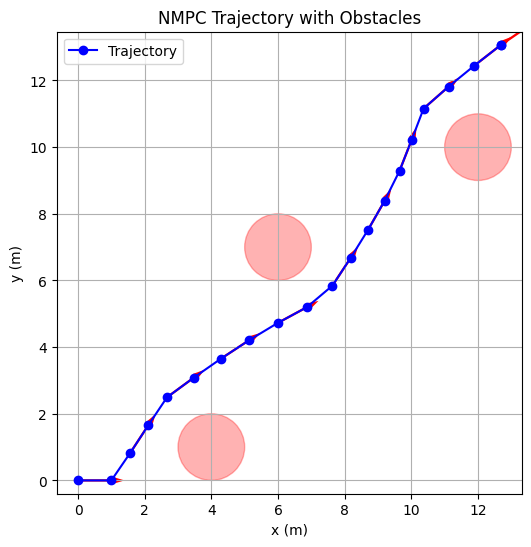

In [233]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 2.0  # horizon length
N = 20   # number of control intervals
dt = T / N

# States and inputs
x = ca.MX.sym('x')
y = ca.MX.sym('y')
theta = ca.MX.sym('theta')
states = ca.vertcat(x, y, theta)
n_states = states.size()[0]

v = ca.MX.sym('v')
w = ca.MX.sym('w')
controls = ca.vertcat(v, w)
n_controls = controls.size()[0]

# Dynamics
rhs = ca.vertcat(
    v * ca.cos(theta),
    v * ca.sin(theta),
    w
)
f = ca.Function('f', [states, controls], [rhs])

# Integrate using Euler
def integrate(xk, uk):
    return xk + dt * f(xk, uk)

# Create optimization problem
opti = ca.Opti()

X = opti.variable(n_states, N+1)
U = opti.variable(n_controls, N)

x0 = opti.parameter(n_states)       # initial state
x_ref = opti.parameter(n_states)    # target


obstacles = np.array([
                        [4, 1, 1],  
                      [6, 7, 1],
                     [12,10,1]
                     ])  # Obstacle 2: center at (3.5, 3.5) with radius 0.6

# Dynamics constraints
opti.subject_to(X[:,0] == x0)
for k in range(N):
    x_next = integrate(X[:,k], U[:,k])
    opti.subject_to(X[:,k+1] == x_next)

# Cost function
Q = ca.diag([10, 10, 1])
R = ca.diag([0.1, 0.1])
cost = 0
for k in range(N):
    cost += ca.mtimes([(X[:,k] - x_ref).T, Q, (X[:,k] - x_ref)])
    cost += ca.mtimes([U[:,k].T, R, U[:,k]])
opti.minimize(cost)

# Control bounds
v_max, w_max = 10.0, 20.0
opti.subject_to(opti.bounded(-v_max, U[0,:], v_max))
opti.subject_to(opti.bounded(-w_max, U[1,:], w_max))

# Add obstacle avoidance constraints
obstacle_min_dist = 2  # Minimum distance to obstacles
for k in range(N+1):
    for obs in obstacles:
        # Compute the distance from the current state to the obstacle
        dist = ca.sqrt((X[0, k] - obs[0])**2 + (X[1, k] - obs[1])**2)  # Euclidean distance
        opti.subject_to(dist >= obstacle_min_dist)  # Constraint to maintain a minimum distance

# Solver
opts = {'ipopt.print_level': 0, 'print_time': 0}
opti.solver('ipopt', opts)

# Solve with example
x0_val = np.array([0, 0, 0])
x_ref_val = np.array([15, 15, 0])

opti.set_value(x0, x0_val)
opti.set_value(x_ref, x_ref_val)

sol = opti.solve()

# Extract and plot
x_sol = sol.value(X)
u_sol = sol.value(U)

# Plot the trajectory and obstacles
plt.figure(figsize=(6, 6))
plt.plot(x_sol[0, :], x_sol[1, :], 'b-o', label="Trajectory")

# Plot orientation arrows
plt.quiver(x_sol[0, ::2], x_sol[1, ::2], np.cos(x_sol[2, ::2]), np.sin(x_sol[2, ::2]),
           scale=10, color='red', width=0.005)

# Plot obstacles as circles
for obs in obstacles:
    circle = plt.Circle((obs[0], obs[1]), obs[2], color='r', alpha=0.3)
    plt.gca().add_artist(circle)

# Make sure the plot axes adjust to the data
plt.axis('equal')  # This will let the plot adjust dynamically based on the data

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("NMPC Trajectory with Obstacles")
plt.grid()
plt.legend()
plt.show()

In [9]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 2.0  # horizon length
N = 20   # number of control intervals
dt = T / N
num_runs = 10  # Number of trials for statistical evaluation

# States and inputs
x = ca.MX.sym('x')
y = ca.MX.sym('y')
theta = ca.MX.sym('theta')
states = ca.vertcat(x, y, theta)
n_states = states.size()[0]

v = ca.MX.sym('v')
w = ca.MX.sym('w')
controls = ca.vertcat(v, w)
n_controls = controls.size()[0]

# Dynamics
rhs = ca.vertcat(
    v * ca.cos(theta),
    v * ca.sin(theta),
    w
)
f = ca.Function('f', [states, controls], [rhs])

def integrate(xk, uk):
    return xk + dt * f(xk, uk)

# Evaluation storage
objective_values = []
iterations = []
successes = 0

for run in range(num_runs):
    opti = ca.Opti()

    X = opti.variable(n_states, N+1)
    U = opti.variable(n_controls, N)

    x0 = opti.parameter(n_states)
    x_ref = opti.parameter(n_states)

    # Example: vary initial condition slightly each run
    x0_val = np.array([0, 0, 0]) + np.random.normal(0, 0.1, size=3)
    x_ref_val = np.array([15, 15, 0])

    obstacles = np.array([
                        [4, 1, 1], 
                        [6, 7, 1], 
                        [12, 10, 1]
                         ])

    # Dynamics constraints
    opti.subject_to(X[:, 0] == x0)
    for k in range(N):
        x_next = integrate(X[:, k], U[:, k])
        opti.subject_to(X[:, k+1] == x_next)

    # Cost
    Q = ca.diag([10, 10, 1])
    R = ca.diag([0.1, 0.1])
    cost = 0
    for k in range(N):
        cost += ca.mtimes([(X[:, k] - x_ref).T, Q, (X[:, k] - x_ref)])
        # cost += ca.mtimes([U[:, k].T, R, U[:, k]])
    opti.minimize(cost)

    # Control bounds
    v_max, w_max = 10.0, 20.0
    opti.subject_to(opti.bounded(-v_max, U[0, :], v_max))
    opti.subject_to(opti.bounded(-w_max, U[1, :], w_max))

    # Obstacle avoidance
    min_dist = 2.0
    for k in range(N+1):
        for obs in obstacles:
            dist = ca.sqrt((X[0, k] - obs[0])**2 + (X[1, k] - obs[1])**2)
            opti.subject_to(dist >= min_dist)

    # Solver options
    opts = {
        'ipopt.print_level': 0,
        'print_time': 0,
        'ipopt.sb': 'yes',
        'ipopt.max_iter': 100,
    }
    opti.solver('ipopt', opts)

    opti.set_value(x0, x0_val)
    opti.set_value(x_ref, x_ref_val)

    try:
        sol = opti.solve()
        obj_val = float(sol.value(opti.f))
        iters = int(opti.stats()['iter_count'])
        objective_values.append(obj_val)
        iterations.append(iters)
        successes += 1
    except RuntimeError:
        # If solver fails
        objective_values.append(np.nan)
        iterations.append(np.nan)

# Compute metrics
objective_values = np.array(objective_values)
iterations = np.array(iterations)
valid_obj = ~np.isnan(objective_values)

avg_obj_val = np.nanmean(objective_values)
std_obj_val = np.nanstd(objective_values)
avg_iterations = np.nanmean(iterations)
success_rate = successes / num_runs * 100

# Print results
print("===== NMPC Performance Metrics over {} runs =====".format(num_runs))
print(f"Average Objective Value      : {avg_obj_val:.4f}")
print(f"Standard Deviation           : {std_obj_val:.4f}")
print(f"Average Convergence Iteration: {avg_iterations:.2f}")
print(f"Success Rate                 : {success_rate:.1f}%")

===== NMPC Performance Metrics over 10 runs =====
Average Objective Value      : 36558.1716
Standard Deviation           : 433.4408
Average Convergence Iteration: 70.20
Success Rate                 : 100.0%


# SQP


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

iter      objective    inf_pr    inf_du 

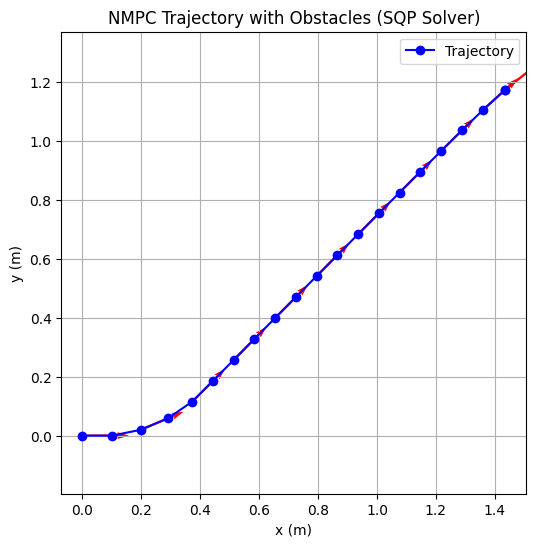

In [16]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 2.0  # horizon length
N = 20   # number of control intervals
dt = T / N

# States and inputs
x = ca.MX.sym('x')
y = ca.MX.sym('y')
theta = ca.MX.sym('theta')
states = ca.vertcat(x, y, theta)
n_states = states.size()[0]

v = ca.MX.sym('v')
w = ca.MX.sym('w')
controls = ca.vertcat(v, w)
n_controls = controls.size()[0]

# Dynamics
rhs = ca.vertcat(
    v * ca.cos(theta),
    v * ca.sin(theta),
    w
)
f = ca.Function('f', [states, controls], [rhs])

# Integrate using Euler
def integrate(xk, uk):
    return xk + dt * f(xk, uk)

# Create optimization problem
opti = ca.Opti()

X = opti.variable(n_states, N+1)
U = opti.variable(n_controls, N)

x0 = opti.parameter(n_states)       # initial state
x_ref = opti.parameter(n_states)    # target

obstacles = np.array([
                    [4, 1, 1],  
                    [6, 5, 1],
                    [1, 10, 1]
                     ])  # Obstacle 2: center at (3.5, 3.5) with radius 0.6

# Dynamics constraints
opti.subject_to(X[:,0] == x0)
for k in range(N):
    x_next = integrate(X[:,k], U[:,k])
    opti.subject_to(X[:,k+1] == x_next)

# Cost function
Q = ca.diag([10, 10, 1])
R = ca.diag([0.1, 0.1])
cost = 0
for k in range(N):
    cost += ca.mtimes([(X[:,k] - x_ref).T, Q, (X[:,k] - x_ref)])
    cost += ca.mtimes([U[:,k].T, R, U[:,k]])
opti.minimize(cost)

# Control bounds
v_max, w_max = 1.0, 2.0
opti.subject_to(opti.bounded(-v_max, U[0,:], v_max))
opti.subject_to(opti.bounded(-w_max, U[1,:], w_max))

# Add obstacle avoidance constraints
obstacle_min_dist = 2  # Minimum distance to obstacles
for k in range(N+1):
    for obs in obstacles:
        # Compute the distance from the current state to the obstacle
        dist = ca.sqrt((X[0, k] - obs[0])**2 + (X[1, k] - obs[1])**2)  # Euclidean distance        
        opti.subject_to(dist >= obstacle_min_dist)  # Constraint to maintain a minimum distance


# Solver options for SQP with more control over verbosity
opts = {
    'qpsol': 'qpoases', 
    'print_time': False, 
    'print_status': False, 
    'max_iter': 100,
    'print_header': False,  # Suppress the header output
    # 'print_iter': False,     # Suppress the iteration details
    'print_out':False,
    'print_in': False,
    # 'print_level': 0
    
}

# Now assign the options and solve
opti.solver('sqpmethod', opts)


# Solve with example
x0_val = np.array([0, 0, 0])
x_ref_val = np.array([15, 15, 0])

opti.set_value(x0, x0_val)
opti.set_value(x_ref, x_ref_val)

sol = opti.solve()

# Extract and plot
x_sol = sol.value(X)
u_sol = sol.value(U)

# Plot the trajectory and obstacles
plt.figure(figsize=(6, 6))
plt.plot(x_sol[0, :], x_sol[1, :], 'b-o', label="Trajectory")

# Plot orientation arrows
plt.quiver(x_sol[0, ::2], x_sol[1, ::2], np.cos(x_sol[2, ::2]), np.sin(x_sol[2, ::2]),
           scale=10, color='red', width=0.005)

# Plot obstacles as circles
for obs in obstacles:
    circle = plt.Circle((obs[0], obs[1]), obs[2], color='r', alpha=0.3)
    plt.gca().add_artist(circle)

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("NMPC Trajectory with Obstacles (SQP Solver)")
plt.axis("equal")
plt.grid()
plt.legend()
plt.show()


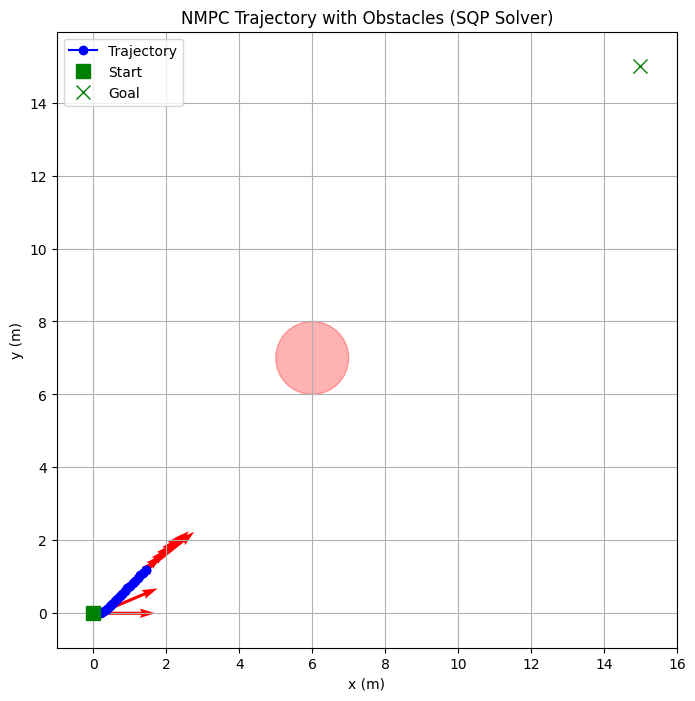

In [8]:
# Extract and plot
x_sol = sol.value(X)
u_sol = sol.value(U)

# Plot the trajectory and obstacles
plt.figure(figsize=(8, 8)) # Increase figure size for better visibility
plt.plot(x_sol[0, :], x_sol[1, :], 'b-o', label="Trajectory")

# Plot orientation arrows
plt.quiver(x_sol[0, ::2], x_sol[1, ::2], np.cos(x_sol[2, ::2]), np.sin(x_sol[2, ::2]),
           scale=10, color='red', width=0.005)

# Plot obstacles as circles
for obs in obstacles:
    circle = plt.Circle((obs[0], obs[1]), obs[2], color='r', alpha=0.3)
    plt.gca().add_artist(circle)

# Plot start and goal
plt.plot(x0_val[0], x0_val[1], 'gs', markersize=10, label="Start")
plt.plot(x_ref_val[0], x_ref_val[1], 'gx', markersize=10, label="Goal")

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("NMPC Trajectory with Obstacles (SQP Solver)")
plt.axis("equal")
plt.grid()
plt.legend()

# Automatically adjust plot limits
x_min = min(np.min(x_sol[0, :]), x0_val[0], x_ref_val[0], np.min(obstacles[:, 0] - obstacles[:, 2])) - 1
x_max = max(np.max(x_sol[0, :]), x0_val[0], x_ref_val[0], np.max(obstacles[:, 0] + obstacles[:, 2])) + 1
y_min = min(np.min(x_sol[1, :]), x0_val[1], x_ref_val[1], np.min(obstacles[:, 1] - obstacles[:, 2])) - 1
y_max = max(np.max(x_sol[1, :]), x0_val[1], x_ref_val[1], np.max(obstacles[:, 1] + obstacles[:, 2])) + 1

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()

In [109]:
print(f"Final Position (x, y): ({x_sol[0, -1]:.3f}, {x_sol[1, -1]:.3f})")

Final Position (x, y): (1.435, 1.174)



qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

iter      objective    inf_pr    inf_du 

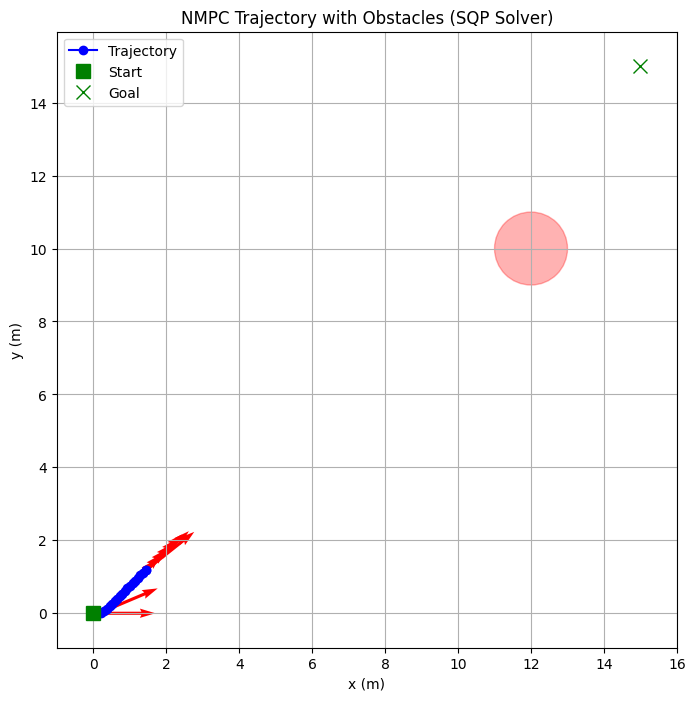

In [3]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 2.0  # horizon length
N = 20   # number of control intervals
dt = T / N

# States and inputs
x = ca.MX.sym('x')
y = ca.MX.sym('y')
theta = ca.MX.sym('theta')
states = ca.vertcat(x, y, theta)
n_states = states.size()[0]

v = ca.MX.sym('v')
w = ca.MX.sym('w')
controls = ca.vertcat(v, w)
n_controls = controls.size()[0]

# Dynamics
rhs = ca.vertcat(
    v * ca.cos(theta),
    v * ca.sin(theta),
    w
)
f = ca.Function('f', [states, controls], [rhs])

# Integrate using Euler
def integrate(xk, uk):
    return xk + dt * f(xk, uk)

# Create optimization problem
opti = ca.Opti()

X = opti.variable(n_states, N+1)
U = opti.variable(n_controls, N)

x0 = opti.parameter(n_states)      # initial state
x_ref = opti.parameter(n_states)   # target

obstacles = np.array([
    # [4, 1, 1],
    # [6, 7, 1],
    [12, 10, 1]
])

# Dynamics constraints
opti.subject_to(X[:,0] == x0)
for k in range(N):
    x_next = integrate(X[:,k], U[:,k])
    opti.subject_to(X[:,k+1] == x_next)

# Cost function
Q = ca.diag([10, 10, 1])
R = ca.diag([0.1, 0.1])
cost = 0
for k in range(N):
    cost += ca.mtimes([(X[:,k] - x_ref).T, Q, (X[:,k] - x_ref)])
    cost += ca.mtimes([U[:,k].T, R, U[:,k]])
opti.minimize(cost)

# Control bounds
v_max, w_max = 1.0, 2.0
opti.subject_to(opti.bounded(-v_max, U[0,:], v_max))
opti.subject_to(opti.bounded(-w_max, U[1,:], w_max))

# Add obstacle avoidance constraints
obstacle_min_dist = 5  # Minimum distance to obstacles
for k in range(N+1):
    for obs in obstacles:
        # Compute the distance from the current state to the obstacle
        dist = ca.sqrt((X[0, k] - obs[0])**2 + (X[1, k] - obs[1])**2)  # Euclidean distance
        opti.subject_to(dist >= obstacle_min_dist)  # Constraint to maintain a minimum distance

# Solver options for SQP with more control over verbosity
opts = {
    'qpsol': 'qpoases',
    'print_time': False,
    'print_status': False,
    'max_iter': 200,
    'print_header': False,
    'print_out': False,
    'print_in': False,
}

# Now assign the options and solve
opti.solver('sqpmethod', opts)

# Solve with example
x0_val = np.array([0, 0, 0])
x_ref_val = np.array([15, 15, 0])

opti.set_value(x0, x0_val)
opti.set_value(x_ref, x_ref_val)

try:
    sol = opti.solve()

    # Extract and plot
    x_sol = sol.value(X)
    u_sol = sol.value(U)

    # Plot the trajectory and obstacles
    plt.figure(figsize=(8, 8))
    plt.plot(x_sol[0, :], x_sol[1, :], 'b-o', label="Trajectory")

    # Plot orientation arrows
    plt.quiver(x_sol[0, ::2], x_sol[1, ::2], np.cos(x_sol[2, ::2]), np.sin(x_sol[2, ::2]),
               scale=10, color='red', width=0.005)

    # Plot obstacles as circles
    for obs in obstacles:
        circle = plt.Circle((obs[0], obs[1]), obs[2], color='r', alpha=0.3)
        plt.gca().add_artist(circle)

    # Plot start and goal
    plt.plot(x0_val[0], x0_val[1], 'gs', markersize=10, label="Start")
    plt.plot(x_ref_val[0], x_ref_val[1], 'gx', markersize=10, label="Goal")

    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.title("NMPC Trajectory with Obstacles (SQP Solver)")
    plt.axis("equal")
    plt.grid()
    plt.legend()

    # Automatically adjust plot limits
    all_x = np.hstack([x_sol[0, :], x0_val[0], x_ref_val[0], obstacles[:, 0]])
    all_y = np.hstack([x_sol[1, :], x0_val[1], x_ref_val[1], obstacles[:, 1]])
    min_x = np.min(all_x) - 1
    max_x = np.max(all_x) + 1
    min_y = np.min(all_y) - 1
    max_y = np.max(all_y) + 1

    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)

    plt.show()

except RuntimeError as e:
    print(f"Solver failed: {e}")
    print("Check if a feasible solution exists given the constraints.")

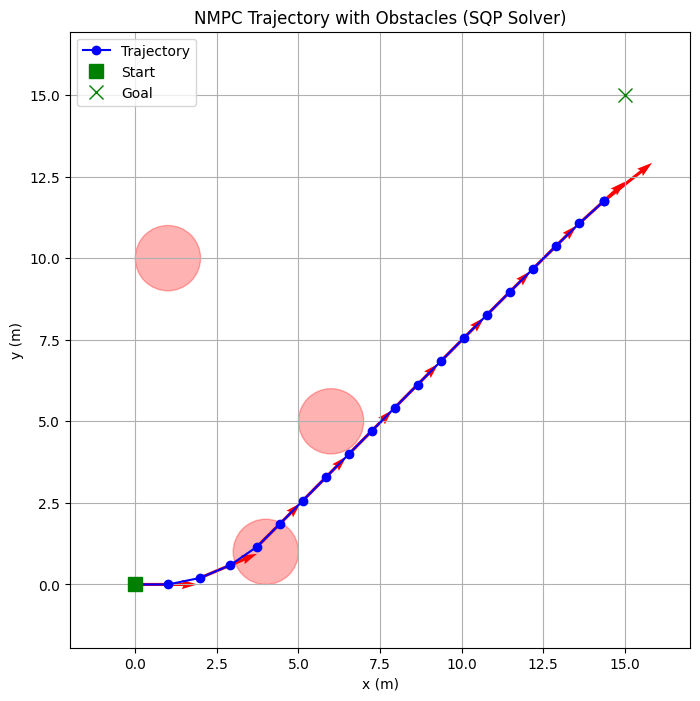

In [17]:
# Extract and plot
x_sol = sol.value(X)
u_sol = sol.value(U)

# Plot the trajectory and obstacles
plt.figure(figsize=(8, 8))
plt.plot(x_sol[0, :]*10, x_sol[1, :]*10, 'b-o', label="Trajectory")

# Plot orientation arrows
plt.quiver(x_sol[0, ::2]*10, x_sol[1, ::2]*10, np.cos(x_sol[2, ::2]), np.sin(x_sol[2, ::2]),
           scale=10, color='red', width=0.005)

# Plot obstacles as circles
for obs in obstacles:
    circle = plt.Circle((obs[0], obs[1]), obs[2], color='r', alpha=0.3)
    plt.gca().add_artist(circle)

# Plot start and goal
plt.plot(x0_val[0], x0_val[1], 'gs', markersize=10, label="Start")
plt.plot(x_ref_val[0], x_ref_val[1], 'gx', markersize=10, label="Goal")

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("NMPC Trajectory with Obstacles (SQP Solver)")
plt.axis("equal")
plt.grid()
plt.legend()

# Automatically adjust plot limits (MOVE THIS BLOCK DOWN)
all_x = np.hstack([x_sol[0, :], x0_val[0], x_ref_val[0], obstacles[:, 0]])
all_y = np.hstack([x_sol[1, :], x0_val[1], x_ref_val[1], obstacles[:, 1]])
min_x = np.min(all_x) - 2  # Increased buffer
max_x = np.max(all_x) + 2  # Increased buffer
min_y = np.min(all_y) - 2  # Increased buffer
max_y = np.max(all_y) + 2  # Increased buffer

plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)

plt.show()

In [15]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 2.0
N = 20
dt = T / N
num_runs = 10

# States and controls
x = ca.MX.sym('x')
y = ca.MX.sym('y')
theta = ca.MX.sym('theta')
states = ca.vertcat(x, y, theta)
n_states = states.size()[0]

v = ca.MX.sym('v')
w = ca.MX.sym('w')
controls = ca.vertcat(v, w)
n_controls = controls.size()[0]

# Dynamics function
rhs = ca.vertcat(v * ca.cos(theta), v * ca.sin(theta), w)
f = ca.Function('f', [states, controls], [rhs])

def integrate(xk, uk):
    return xk + dt * f(xk, uk)

# Obstacle list
obstacles = np.array([
    [4, 1, 1],  
    [6, 5, 1],
    [1, 10, 1]
])
obstacle_min_dist = 2.0

# Evaluation containers
objective_values = []
iterations = []
successes = 0

# Run the solver multiple times
for i in range(num_runs):
    opti = ca.Opti()

    X = opti.variable(n_states, N+1)
    U = opti.variable(n_controls, N)
    x0 = opti.parameter(n_states)
    x_ref = opti.parameter(n_states)

    # Add noise to initial condition
    x0_val = np.array([0, 0, 0]) + np.random.normal(0, 0.1, size=3)
    x_ref_val = np.array([15, 15, 0])

    # Dynamics constraints
    opti.subject_to(X[:, 0] == x0)
    for k in range(N):
        opti.subject_to(X[:, k+1] == integrate(X[:, k], U[:, k]))

    # Cost function
    Q = ca.diag([10, 10, 1])
    R = ca.diag([0.1, 0.1])
    cost = 0
    for k in range(N):
        cost += ca.mtimes([(X[:, k] - x_ref).T, Q, (X[:, k] - x_ref)])
        cost += ca.mtimes([U[:, k].T, R, U[:, k]])
    opti.minimize(cost)

    # Control bounds
    v_max, w_max = 1.0, 2.0
    opti.subject_to(opti.bounded(-v_max, U[0, :], v_max))
    opti.subject_to(opti.bounded(-w_max, U[1, :], w_max))

    # Obstacle avoidance
    for k in range(N+1):
        for obs in obstacles:
            dist = ca.sqrt((X[0, k] - obs[0])**2 + (X[1, k] - obs[1])**2)
            opti.subject_to(dist >= obstacle_min_dist)

    # SQP Solver options
    opts = {
        'qpsol': 'qpoases',
        'print_time': False,
        'print_status': False,
        'max_iter': 100,
        'print_header': False,
        'print_out': False,
        'print_in': False,
    }
    opti.solver('sqpmethod', opts)

    # Set values and solve
    opti.set_value(x0, x0_val)
    opti.set_value(x_ref, x_ref_val)

    try:
        sol = opti.solve()
        obj_val = float(sol.value(opti.f))
        stats = opti.stats()
        n_iter = stats['iter_count'] if 'iter_count' in stats else np.nan

        objective_values.append(obj_val)
        iterations.append(n_iter)
        successes += 1
    except RuntimeError:
        objective_values.append(np.nan)
        iterations.append(np.nan)

# Compute stats
objective_values = np.array(objective_values)
iterations = np.array(iterations)

valid_obj = ~np.isnan(objective_values)
avg_obj_val = np.nanmean(objective_values)
std_obj_val = np.nanstd(objective_values)
avg_iters = np.nanmean(iterations)
success_rate = 100.0 * successes / num_runs

# Print summary
print("===== SQP NMPC Performance Summary =====")
print(f"Number of Runs                : {num_runs}")
print(f"Success Rate                  : {success_rate:.1f}%")
print(f"Average Objective Value       : {avg_obj_val:.4f}")
print(f"Standard Deviation of Obj Val : {std_obj_val:.4f}")
print(f"Average Convergence Iteration : {avg_iters:.2f}")


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

iter      objective    inf_pr    inf_du 

In [16]:
# Print summary
print("===== SQP NMPC Performance Summary =====")
print(f"Number of Runs                : {num_runs}")
print(f"Success Rate                  : {success_rate:.1f}%")
print(f"Average Objective Value       : {avg_obj_val:.4f}")
print(f"Standard Deviation of Obj Val : {std_obj_val:.4f}")
print(f"Average Convergence Iteration : {avg_iters:.2f}")

===== SQP NMPC Performance Summary =====
Number of Runs                : 10
Success Rate                  : 100.0%
Average Objective Value       : 82933.5710
Standard Deviation of Obj Val : 868.9532
Average Convergence Iteration : 6.90
